## What is the correlation between the proportion of COVID-19 deaths and proportion of people vaccinated?

We will explore this question on the state level and plot a scatter plot of the proportion of COVID-19 deaths and proportion of people vaccinated for each state.

Dataframes are grouped by state individually then merged together into a single dataframe. Once merged, a scatterplot is created with labels for each state and the correlation coefficient is displayed.

### Data used
- CDC Vaccinations
- CDC COVID-19 Deaths
- 2020 US Population Census

In [1]:
import datetime
import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Retrieve vaccine data from CDC
cdc_completed_vaccinations_endpoint = 'https://data.cdc.gov/resource/8xkx-amqh.json?$limit=5000'
r = requests.get(cdc_completed_vaccinations_endpoint)
cdc_county_vaccination_counts = pd.DataFrame(r.json())
cdc_county_vaccination_counts.head()

,date,fips,mmwr_week,recip_county,recip_state,series_complete_pop_pct,series_complete_yes,series_complete_18plus,series_complete_18pluspop,series_complete_65plus,...,series_complete_65pluspop_pct_svi,metro_status,series_complete_pop_pct_ur_equity,series_complete_12pluspop_pct_ur_equity,series_complete_18pluspop_pct_ur_equity,series_complete_65pluspop_pct_ur_equity,series_complete_12plus,series_complete_12pluspop,administered_dose1_recip_12plus,administered_dose1_recip_12pluspop_pct
0,2021-12-09T00:00:00.000,16007,49,Bear Lake County,ID,41,2514,2504,55.9,1129,...,4,Non-metro,7,7,8,8,NaN,NaN,NaN,NaN
1,2021-12-09T00:00:00.000,UNK,49,Unknown County,FL,0,170179,168200,0,44799,...,NaN,NaN,NaN,NaN,NaN,NaN,170000,0.0,217769,0.0
2,2021-12-09T00:00:00.000,09011,49,New London County,CT,73.7,195507,181215,84.6,48012,...,8,Metro,4,4,4,4,193623,83.2,217951,93.6
3,2021-12-09T00:00:00.000,04019,49,Pima County,AZ,62.3,652135,605001,72.7,193683,...,16,Metro,4,4,4,4,646590,71.4,741442,81.9
4,2021-12-09T00:00:00.000,19057,49,Des Moines County,IA,48.1,18725,17831,59.1,6810,...,8,Non-metro,7,8,8,8,18627,56.1,20259,61.0


In [3]:
# Filter data for states and counts 
vax_counts_by_state = cdc_county_vaccination_counts.filter(
    [
        'date',
        'recip_state',
        'series_complete_yes'
    ]
)

# Filter by today's date in format YYYY-MM-DD
today = datetime.datetime(2021, 12, 9).strftime('%Y-%m-%d')
today = today + 'T00:00:00.000'
vax_counts_by_state = vax_counts_by_state[
    vax_counts_by_state['date'] == today
]

# Turn completed vaccination counts into integers
vax_counts_by_state['series_complete_yes'] = vax_counts_by_state['series_complete_yes'].astype(int)
vax_counts_by_state['State Abbreviation'] = vax_counts_by_state['recip_state'].str.upper()

# Group counts by state
vax_counts_by_state = vax_counts_by_state.groupby('State Abbreviation').sum()

# Filter for states with at least 100 completed vaccinations
vax_counts_by_state = vax_counts_by_state[vax_counts_by_state['series_complete_yes'] >= 100]

vax_counts_by_state.head()

,series_complete_yes
State Abbreviation,
AK,404199
AL,2288180
AR,1510981
AS,31594
AZ,4043529


In [4]:
# Import population data for each state
state_populations = pd.read_csv('../data/census-2020-county-population-totals.csv')

# Keep only state wide data
state_populations = state_populations[
    state_populations['STNAME'] == state_populations['CTYNAME']
]

# Filter columns 
state_populations['State Name'] = state_populations['STNAME'].str.upper()
state_populations = state_populations.filter(
    ['State Name', 'POPESTIMATE2020']
)

# Sum county populations
state_populations = state_populations.groupby('State Name').sum()   

state_populations.head()

,POPESTIMATE2020
State Name,
ALABAMA,4921532
ALASKA,731158
ARIZONA,7421401
ARKANSAS,3030522
CALIFORNIA,39368078


In [5]:
# Merge vaccination counts with population data on state abbreviations
state_abbreviations = pd.read_csv('../data/state-abbreviations.csv')

# Add state abr to state populations
state_populations = state_populations.join(state_abbreviations.set_index('State Name'), on='State Name')
state_populations.head()

# Join
state_vaccine_df = vax_counts_by_state.join(
    state_populations.reset_index().set_index('State Abbreviation'),
).dropna(how='any')

state_vaccine_df.head()

,series_complete_yes,State Name,POPESTIMATE2020
State Abbreviation,,,
AK,404199,ALASKA,731158.0
AL,2288180,ALABAMA,4921532.0
AR,1510981,ARKANSAS,3030522.0
AZ,4043529,ARIZONA,7421401.0
CA,25429366,CALIFORNIA,39368078.0


In [6]:
# Calculate vaccine proportions
state_vaccine_df['Vaccine Proportion'] = state_vaccine_df['series_complete_yes'] / state_vaccine_df['POPESTIMATE2020']
state_vaccine_df.head()

,series_complete_yes,State Name,POPESTIMATE2020,Vaccine Proportion
State Abbreviation,,,,
AK,404199,ALASKA,731158.0,0.552820
AL,2288180,ALABAMA,4921532.0,0.464932
AR,1510981,ARKANSAS,3030522.0,0.498588
AZ,4043529,ARIZONA,7421401.0,0.544847
CA,25429366,CALIFORNIA,39368078.0,0.645939


In [7]:
# Calculate proportion of COVID-19 deaths per state
# Every county has 3 repeating rows
county_deaths = pd.read_csv('../data/cdc-deaths-by-county-and-race.csv')
county_deaths = county_deaths.iloc[::3]

state_deaths = county_deaths.groupby('State').sum()
state_deaths = state_deaths.filter(['Total deaths', 'COVID-19 Deaths'])

state_deaths['COVID-19 Death Proportion'] = state_deaths['COVID-19 Deaths'] / state_deaths['Total deaths']
state_deaths.index.rename('State Abbreviation', inplace=True)

state_deaths.head()


,Total deaths,COVID-19 Deaths,COVID-19 Death Proportion
State Abbreviation,,,
AK,7025,764,0.108754
AL,104758,14461,0.138042
AR,51752,7338,0.141792
AZ,145717,20202,0.138639
CA,600256,77073,0.128400


In [8]:
# Join vaccine and death data
state_vaccine_df = state_vaccine_df.join(
    state_deaths)
state_vaccine_df.head() 

,series_complete_yes,State Name,POPESTIMATE2020,Vaccine Proportion,Total deaths,COVID-19 Deaths,COVID-19 Death Proportion
State Abbreviation,,,,,,,
AK,404199,ALASKA,731158.0,0.552820,7025,764,0.108754
AL,2288180,ALABAMA,4921532.0,0.464932,104758,14461,0.138042
AR,1510981,ARKANSAS,3030522.0,0.498588,51752,7338,0.141792
AZ,4043529,ARIZONA,7421401.0,0.544847,145717,20202,0.138639
CA,25429366,CALIFORNIA,39368078.0,0.645939,600256,77073,0.128400


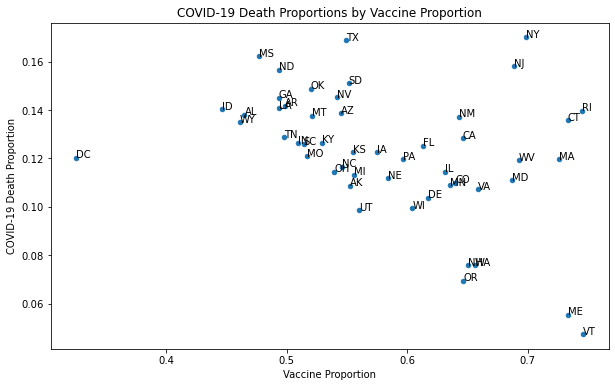

In [9]:
# Plot
state_vaccine_df.plot(
    x='Vaccine Proportion',
    y='COVID-19 Death Proportion',
    kind='scatter',
    title='COVID-19 Death Proportions by Vaccine Proportion',
    figsize=(10, 6)
)

# Annotate points
for idx, row in state_vaccine_df.iterrows(): 
    plt.text(row['Vaccine Proportion'], row['COVID-19 Death Proportion'], idx)

In [10]:
# Compute correlation coefficient
death_vax_correlation = state_vaccine_df['Vaccine Proportion'].corr(state_vaccine_df['COVID-19 Death Proportion'])
print(f'Correlation coefficient: {death_vax_correlation}')

Correlation coefficient: -0.4002944976189329


## Conclusion:
This scatter plot and negative correlation coeffifient indicates that the proportion of COVID-19 deaths decreases as the proportion of people vaccinated increases. This is a good indication on the benefits of vaccination.

Hawaii was the only state ommited from the analysis due to the lack of vaccination data. 